### Stock Forecaster

In [1]:
from lib.forecast import StockForecaster
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
import requests
from json import dumps
from os import getenv

def get_data_from_polygon(ticker, candle_size, timeframe="minute", api_key=None):
    
    # get from datetime
    year = 2023
    month = "06"
    day = "24"
    
    start_date = f"{year-2}-{month}-{day}"
    end_date = f"{year}-{month}-{day}"
    
    ticker = ticker.upper()
    url = (
        f"https://api.polygon.io/v2/aggs/ticker/{ticker}/range/{candle_size}/{timeframe}/{start_date}/"
        f"{end_date}?adjusted=true&sort=asc&limit=50000&apiKey={api_key}"
    )
    print(url)
    d = requests.get(url)
    raw_data = d.json()

    fn = f"{ticker}-{start_date}-{end_date}.json"
    with open(fn, "w") as outf:
        try:
            outf.write(dumps(raw_data["results"]))
        except Exception as ex:
            print(ex)
            print(raw_data)

    return fn

key = getenv("POLYKEY")
fn = get_data_from_polygon("aapl", 15, key)
print(fn)

AAPL-2021-06-24-2023-06-24.json


In [5]:
train_on = ["v", "vw", "o", "c", "h", "l", "n"]
target = "c"

sf = StockForecaster(epochs=1000,lr=0.001, hidden_size=20, gpu_device="mps", train_on=train_on, target=target)
sf.load(fn, start_at = 0)

# sf = StockForecaster(epochs=900,lr=0.001, hidden_size=20, gpu_device="mps")
# sf.load("AAPL.csv", start_at = 8600)

sf.prepare()
sf.create_model()
# len(sf.raw_data)

Index(['v', 'vw', 'o', 'c', 'h', 'l', 'n'], dtype='object')


In [7]:
sf.raw_data.head(5)

,v,vw,o,c,h,l,n
0,10866,134.0817,133.83,134.25,134.25,133.83,234
1,2455,134.2088,134.21,134.20,134.25,134.07,88
2,1032,134.2220,134.26,134.28,134.28,134.15,30
3,1244,134.2229,134.25,134.21,134.25,134.21,26
4,3927,134.2798,134.29,134.30,134.30,134.26,84


<Axes: >

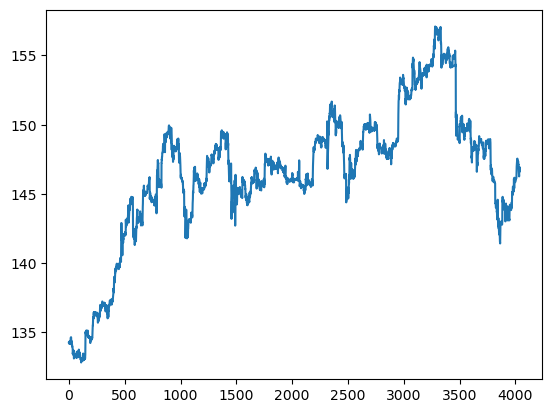

In [16]:
sf.raw_data["c"].plot()

#### Train Model

In [17]:
loss_data, test_loss_data = sf.train()

Epoch: 0, train loss: 0.396506667137146, test loss: 0.314663290977478
Epoch: 100, train loss: 0.0029558036476373672, test loss: 0.0036061496939510107
Epoch: 200, train loss: 0.0023102255072444677, test loss: 0.0030466336756944656
Epoch: 300, train loss: 0.002229251665994525, test loss: 0.0030302945524454117
Epoch: 400, train loss: 0.002186630154028535, test loss: 0.003035204019397497
Epoch: 500, train loss: 0.002156251110136509, test loss: 0.0030360505916178226
Epoch: 600, train loss: 0.002129986882209778, test loss: 0.0030459242407232523
Epoch: 700, train loss: 0.0020959165412932634, test loss: 0.003062058240175247
Epoch: 800, train loss: 0.002065506065264344, test loss: 0.0030772096943110228
Epoch: 900, train loss: 0.0020381149370223284, test loss: 0.0030985053163021803


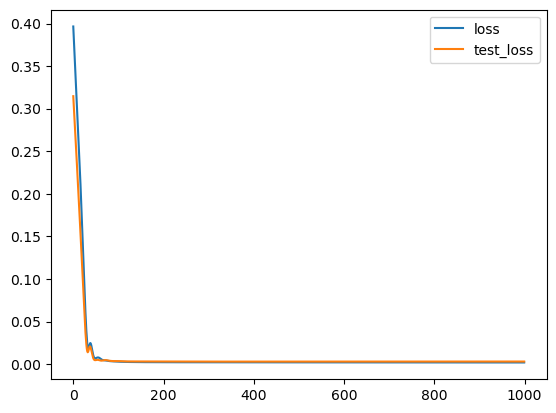

In [18]:
plt.plot(loss_data, label="loss")
plt.plot(test_loss_data, label="test_loss")
plt.legend()
plt.show()

#### Validate

<Axes: >

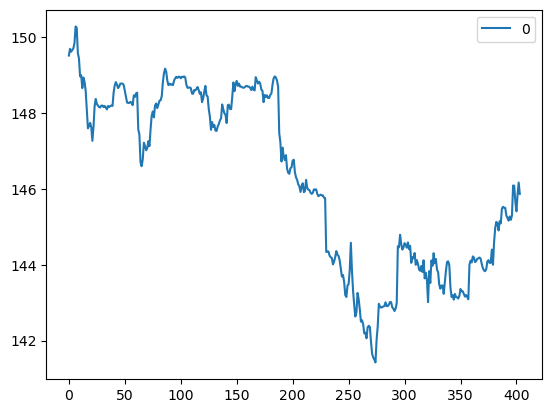

In [19]:
train_data = sf.ss.inverse_transform(sf.X_train_tensors.data.numpy()[:,0,:])[:,2]
test_data = sf.mm.inverse_transform(sf.y_test_tensors)[:,2]

train_predict = sf.lstm(sf.X_test_tensors) 
data_predict = sf.mm.inverse_transform(train_predict.data.numpy())[:,0]
pd.DataFrame(test_data).plot()

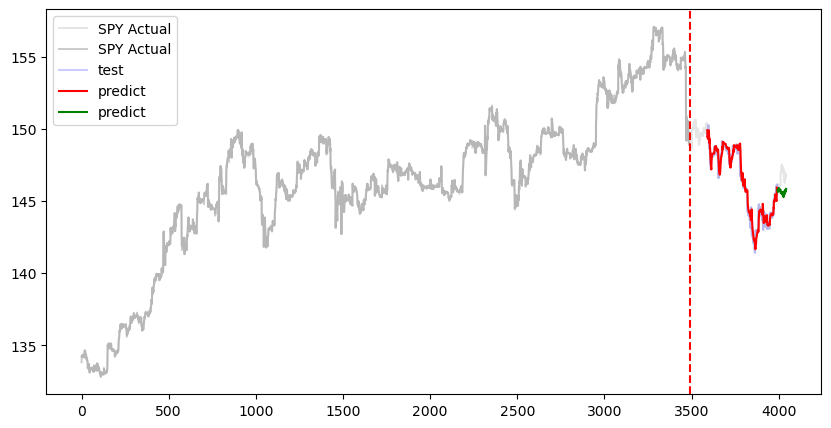

In [20]:
tdata_len = len(train_data)

plt.figure(figsize=(10,5)) #plotting

plt.plot(sf.mm.inverse_transform(sf.y_train), "k", label="SPY Actual", alpha=0.1)

plt.plot(train_data, "k", label="SPY Actual", alpha=0.2)

td = [None] * (tdata_len + 100)
td.extend(test_data)
plt.plot(td, "b", label="test", alpha=0.2)

dp = [None] * (tdata_len + 100)
dp.extend(data_predict)
plt.plot(dp, "r", label="predict")

test_predict = sf.lstm(sf.X_test_tensors[-1].unsqueeze(0)) # get the last sample
test_predict = test_predict.detach().numpy()
test_predict = sf.mm.inverse_transform(test_predict)
test_predict = test_predict[0].tolist()

dp = [None] * (tdata_len + 100 + len(data_predict))
dp.extend(test_predict)
plt.plot(dp, "g", label="predict")


plt.axvline(x=len(train_data), c='r', linestyle='--') # size of the training set

plt.legend()

plt.savefig("full_prediction.png", dpi=300)

plt.show()

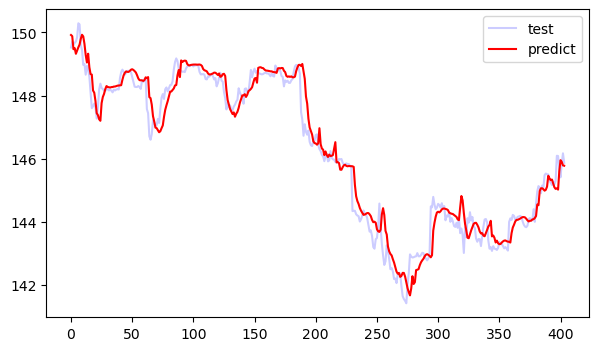

In [21]:
plt.figure(figsize=(7,4)) #plotting

td = test_data
plt.plot(td, "b", label="test", alpha=0.2)

dp = data_predict
plt.plot(dp, "r", label="predict")

plt.legend()
plt.savefig("prediction.png", dpi=300)

plt.show()

### Future Price

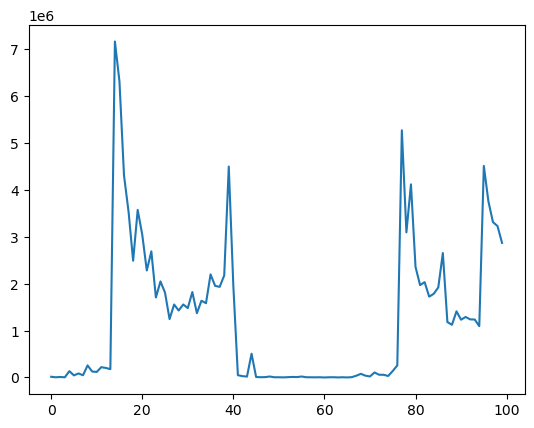

In [22]:
ds = sf.X_test_tensors[-1].unsqueeze(0)
plt.plot(sf.ss.inverse_transform(ds.detach().numpy()[0])[:, 0])

In [23]:
len(sf.X_train_tensors.data.numpy()) + len(sf.X_test_tensors.data.numpy())

3893

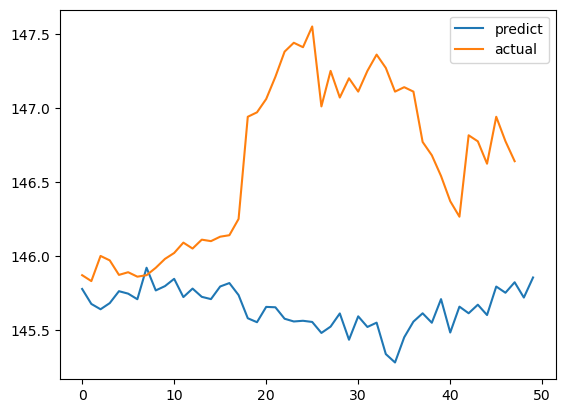

In [24]:
test_predict = sf.lstm(sf.X_test_tensors[-1].unsqueeze(0)) # get the last sample
test_predict = test_predict.detach().numpy()
test_predict = sf.mm.inverse_transform(test_predict)
test_predict = test_predict[0].tolist()

known_length = len(sf.X_train_tensors.data.numpy()) + len(sf.X_test_tensors.data.numpy())
test_target = sf.raw_data.c[known_length+100:].reset_index(drop=True)
# test_target = sf.y_test_tensors[-1].detach().numpy() # last sample again
# test_target = sf.mm.inverse_transform(test_target.reshape(1, -1))
# test_target = test_target[0].tolist()

plt.plot(test_predict, label="predict")
plt.plot(test_target, label="actual")
plt.legend()
plt.savefig("prediction_future.png", dpi=300)

plt.show()